# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/AIML/Labs/R9/"
TRAIN_CSV = path + 'train_labels.csv'
RAR_PATH = path + 'images_racoon (1).rar'
ALPHa = 1

### Load the training data from train.csv file

In [0]:
data = pd.read_csv(TRAIN_CSV)

### Print the shape of the train dataset

In [7]:
data.shape

(173, 8)

In [8]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile), 4))
  reader = csv.reader(csvfile, delimiter=',')
  csvfile.seek(0)
  next(reader)
  for col, row in enumerate(reader):
    for i, r in enumerate(row[1:7]):
      row[i+1] = r
    filename, width, height, _,	xmin,	ymin,	xmax,	ymax = row
    path = filename
    coords[col, 0] = (int(xmin)) * IMAGE_SIZE / (int(width)) # Normalize bounding box by image size
    coords[col, 1] = (int(ymin)) * IMAGE_SIZE / (int(height)) # Normalize bounding box by image size
    coords[col, 2] = ((int(xmax)) - (int(xmin))) * IMAGE_SIZE / (int(width)) # Normalize bounding box by image size
    coords[col, 3] = ((int(ymax)) - (int(ymin))) * IMAGE_SIZE / (int(height))
    paths.append(path)

In [73]:
len(paths)

173

In [0]:
coords = coords[0:173]

In [96]:
len(coords)

173

In [76]:
!pip install patool
import patoolib
patoolib.extract_archive(RAR_PATH)

patool: Extracting /content/drive/My Drive/AIML/Labs/R9/images_racoon (1).rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/AIML/Labs/R9/images_racoon (1).rar"
patool:     with cwd='./Unpack_hrj_m6lr'
patool: ... /content/drive/My Drive/AIML/Labs/R9/images_racoon (1).rar extracted to `images'.


'images'

In [0]:
EXTRACTED_IMAGES_PATH = '/content/images/'

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(EXTRACTED_IMAGES_PATH + f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


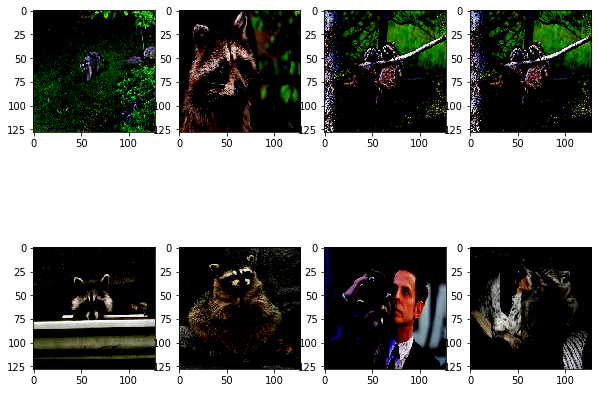

In [83]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 8)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(batch_images[i])

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [87]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHa)

for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 1s 0us/step


In [89]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [115]:
batch_images.shape

(173, 128, 128, 3)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [97]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,coords,
            epochs=10,batch_size = 32,
            verbose=1)



Epoch 1/10
173/173 [==============================] - 6s 32ms/step - loss: 2786.9803 - IoU: 0.0848
Epoch 2/10
173/173 [==============================] - 5s 26ms/step - loss: 669.3035 - IoU: 0.4309
Epoch 3/10
173/173 [==============================] - 5s 27ms/step - loss: 643.9491 - IoU: 0.5345
Epoch 4/10
173/173 [==============================] - 5s 26ms/step - loss: 559.8464 - IoU: 0.5279
Epoch 5/10
173/173 [==============================] - 4s 26ms/step - loss: 347.5210 - IoU: 0.5811
Epoch 6/10
173/173 [==============================] - 5s 26ms/step - loss: 277.2234 - IoU: 0.5752
Epoch 7/10
173/173 [==============================] - 5s 26ms/step - loss: 245.5920 - IoU: 0.6078
Epoch 8/10
173/173 [==============================] - 5s 26ms/step - loss: 189.7279 - IoU: 0.6597
Epoch 9/10
173/173 [==============================] - 5s 26ms/step - loss: 168.1927 - IoU: 0.6963
Epoch 10/10
173/173 [==============================] - 5s 26ms/step - loss: 140.7292 - IoU: 0.7134


### Pick a test image from the given data

In [0]:
test_image = '/content/images/raccoon-102.jpg'

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [100]:
import cv2
unscaled = cv2.imread(test_image)
unscaled.shape

(194, 259, 3)

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

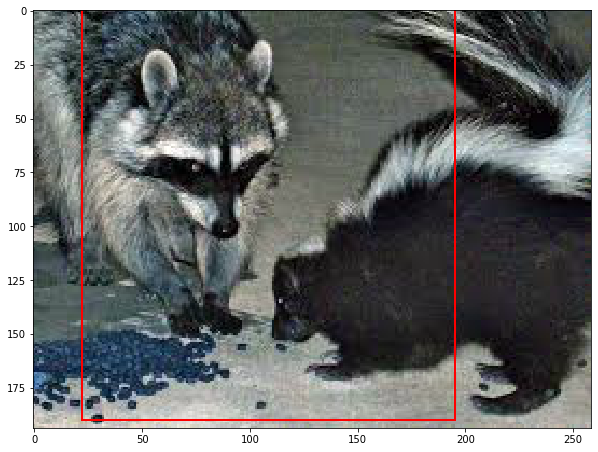

In [103]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

### Load your data file

In [117]:
temp_data = pd.read_csv('/content/drive/My Drive/AIML/Labs/R9/daily-minimum-temperatures-in-me.csv')
temp_data.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [119]:
temp_data.shape

(3650, 2)

#### Plot data

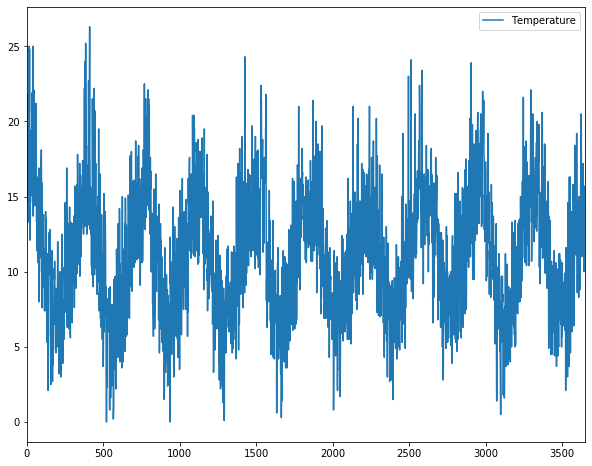

In [120]:
temp_data.plot()

#### Descibe your dataframe

In [121]:
temp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


#### Check for null values

In [122]:
temp_data.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [124]:
temp_data.dropna(inplace=True)
temp_data.shape

(3650, 2)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cc9ece550>]],
      dtype=object)

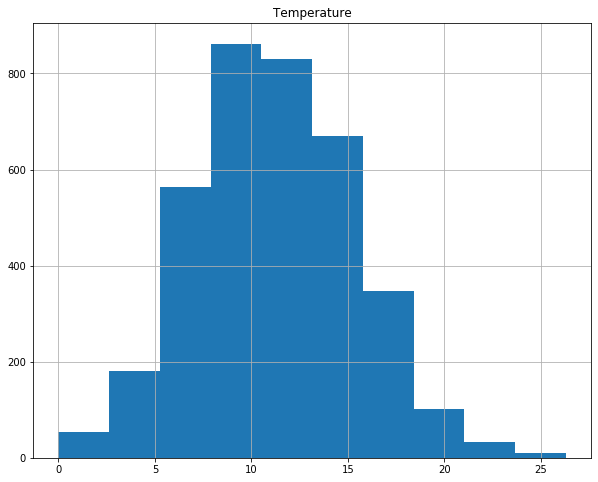

In [125]:
temp_data.hist()

#### Check the maximum and minimum values

In [126]:
temp_data.min()

Date           1981-01-01
Temperature             0
dtype: object

In [127]:
temp_data.max()

Date           1990-12-31
Temperature          26.3
dtype: object

In [129]:
data = temp_data.drop('Date', axis=1)
data.head()

,Temperature
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

#### Check the maximum and minimum values of scaled data

In [132]:
print("Min Scaled value:", scaled.min())
print("Min Scaled value:", scaled.max())

Min Scaled value: 0.0
Min Scaled value: 1.0


#### Look into some of the scaled values

In [134]:
scaled[2:10]

array([[0.7148289 ],
       [0.55513308],
       [0.60076046],
       [0.60076046],
       [0.60076046],
       [0.66159696],
       [0.82889734],
       [0.76045627]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled)*0.7)
test_size = len(scaled)-train_size

In [0]:
train, test = scaled[0: train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [142]:
print("Train Size:", len(train))
print("Test Size:", len(test))

Train Size: 2555
Test Size: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [144]:
X_train.shape

(2554, 1, 1)

## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
import tensorflow as tf

In [146]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1))) #32 is amount of memory to remember
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Summarize your model

In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [148]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 1s 535us/sample - loss: 0.0901 - val_loss: 0.0290
Epoch 2/200
2554/2554 [==============================] - 0s 109us/sample - loss: 0.0159 - val_loss: 0.0126
Epoch 3/200
2554/2554 [==============================] - 0s 106us/sample - loss: 0.0134 - val_loss: 0.0120
Epoch 4/200
2554/2554 [==============================] - 0s 111us/sample - loss: 0.0127 - val_loss: 0.0112
Epoch 5/200
2554/2554 [==============================] - 0s 106us/sample - loss: 0.0121 - val_loss: 0.0108
Epoch 6/200
2554/2554 [==============================] - 0s 109us/sample - loss: 0.0116 - val_loss: 0.0100
Epoch 7/200
2554/2554 [==============================] - 0s 105us/sample - loss: 0.0111 - val_loss: 0.0096
Epoch 8/200
2554/2554 [==============================] - 0s 106us/sample - loss: 0.0107 - val_loss: 0.0094
Ep

## Make Predictions and Evaluate your model

In [0]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [150]:
testPredict

array([[0.54708105],
       [0.51902634],
       [0.49632728],
       ...,
       [0.49917692],
       [0.49632728],
       [0.55820215]], dtype=float32)

## Plot the results

In [0]:

import matplotlib.pyplot as plt

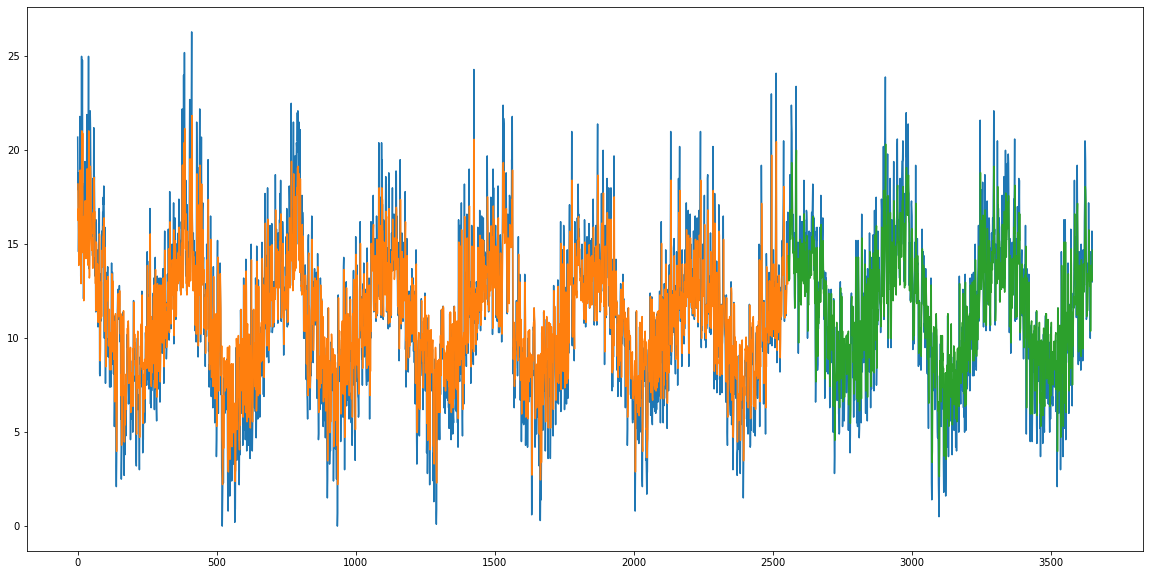

In [152]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)


trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

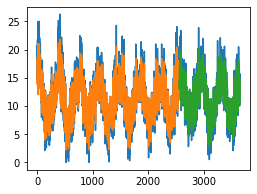

In [153]:
plt.figure(figsize=(4,3))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()